Task 0 accuracy: [0.88599998]
Task 1 accuracy: [0.88599998 0.94214284]
Task 2 accuracy: [0.88599998 0.94214284 0.917     ]
Task 3 accuracy: [0.88599998 0.94214284 0.917      0.91416669]
Task 4 accuracy: [0.88599998 0.94214284 0.917      0.91416669 0.91214287]
   Task        AA       AIA   FM        IM  Task 0 Acc
0     0  0.886000  0.886000  0.0  0.000000       0.886
1     1  0.914071  0.900036  0.0 -0.028071       0.886
2     2  0.915048  0.905040  0.0 -0.001952       0.886
3     3  0.914827  0.907487  0.0  0.000661       0.886
4     4  0.914290  0.908847  0.0  0.002148       0.886


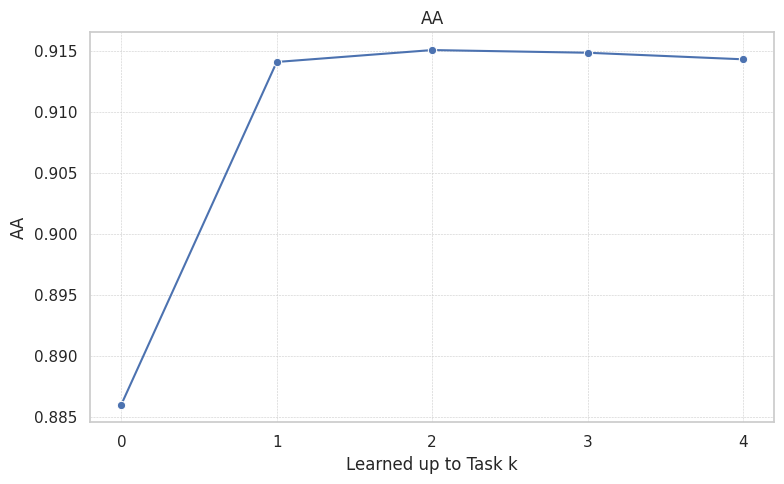

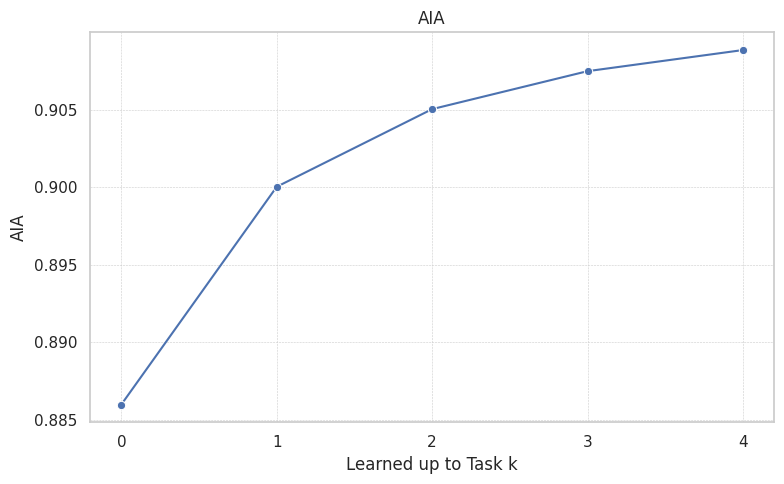

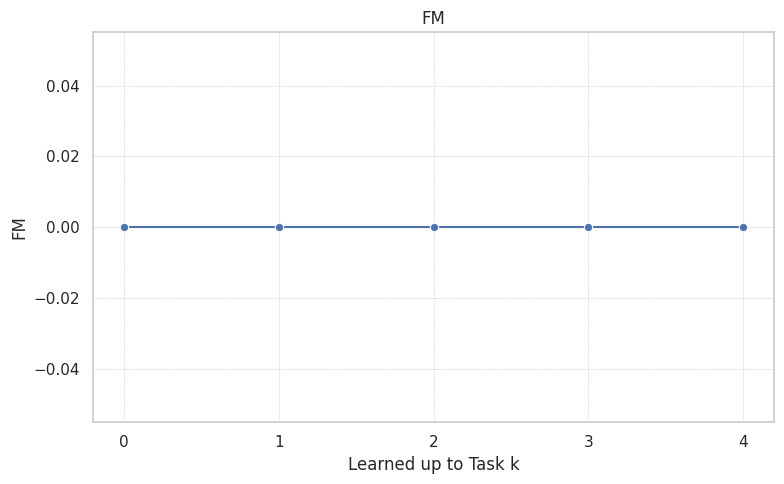

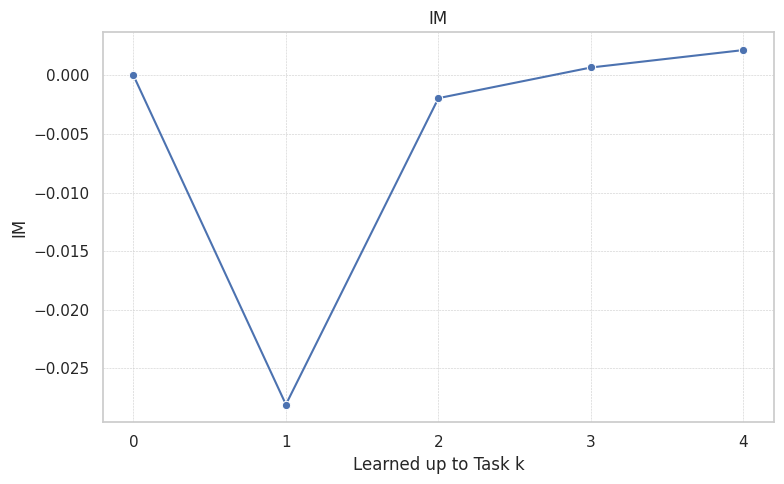

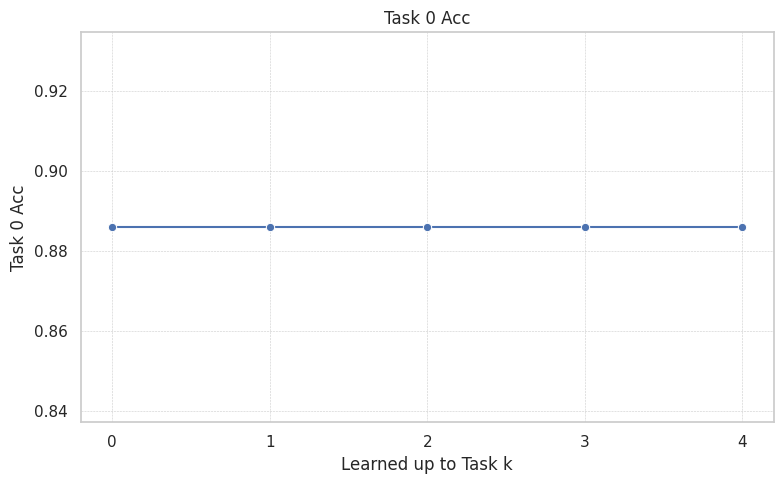

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- ファイルパス ---
pnn_csv = "/work/csv/uci-har/cil-pnn.csv"
joint_csv = "/work/csv/uci-har/cil-joint/ltc_ncps.csv"  # joint-training の結果

# --- CSV 読み込み ---
df_pnn = pd.read_csv(pnn_csv)
df_joint = pd.read_csv(joint_csv) if os.path.exists(joint_csv) else None

# --- acc_matrix の構築 ---
num_tasks = int(df_pnn["task"].nunique())
acc_matrix = np.zeros((num_tasks, num_tasks), dtype=float)

for k in range(num_tasks):
    val = df_pnn.loc[df_pnn["task"] == k, "テスト精度 (Test Acc)"].values[0]
    if k == 0:
        acc_matrix[k, 0] = val
    else:
        acc_matrix[k, :k] = acc_matrix[k-1, :k]  # 前タスクの精度をコピー
        acc_matrix[k, k] = val                  # 今のタスク精度を最後に追加
    print(f"Task {k} accuracy: {acc_matrix[k, :k+1]}")



# --- Joint baseline の読み取り ---
if df_joint is not None:
    joint_acc = df_joint["テスト精度 (Test Acc)"].values[:num_tasks]
else:
    joint_acc = None

# --- 指標計算関数 ---
def compute_metrics(acc_matrix: np.ndarray, joint_acc: np.ndarray | None = None):
    num_tasks = acc_matrix.shape[0]
    AA_list, AIA_list, FM_list, IM_list, Task0_list = [], [], [], [], []

    for k in range(num_tasks):
        # AA_k: 学習タスク k 後の 0..k の平均精度
        AA_k = float(np.mean(acc_matrix[k, :k+1]))
        AA_list.append(AA_k)

        # AIA_k: これまでの AA の平均
        AIA_k = float(np.mean(AA_list))
        AIA_list.append(AIA_k)

        # FM_k: forgetting measure
        if k == 0:
            FM_k = 0.0
        else:
            forgetting = []
            for t in range(k):
                past_accs = [acc_matrix[l, t] for l in range(t, k)]  # l=t..k-1
                max_past = float(np.max(past_accs))
                current = float(acc_matrix[k, t])
                forgetting.append(max_past - current)
            FM_k = np.mean(forgetting)
        FM_list.append(FM_k)

        # IM_k: AA_k - joint_acc[k]
        if joint_acc is None or np.isnan(joint_acc[k]):
            IM_k = float("nan")
        else:
            IM_k = AA_k - float(joint_acc[k])
        IM_list.append(IM_k)

        # Task0精度
        Task0_list.append(float(acc_matrix[k, 0]))

    metrics_df = pd.DataFrame({
        "Task": list(range(num_tasks)),
        "AA": AA_list,
        "AIA": AIA_list,
        "FM": FM_list,
        "IM": IM_list,
        "Task 0 Acc": Task0_list
    })
    return metrics_df

metrics_df = compute_metrics(acc_matrix, joint_acc)
print(metrics_df)

# --- 可視化 ---
sns.set(style="whitegrid")
for metric in ["AA", "AIA", "FM", "IM", "Task 0 Acc"]:
    plt.figure(figsize=(8,5))
    sns.lineplot(data=metrics_df, x="Task", y=metric, marker="o")
    plt.title(metric)
    plt.xlabel("Learned up to Task k")
    plt.xticks(range(num_tasks))
    plt.grid(True, linestyle="--", linewidth=0.4)
    plt.tight_layout()
    plt.show()
